In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import random
import nltk
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
from IPython.display import display, HTML
import collections

# Setting width of the notebook to 85% of screen width
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

%matplotlib inline
nltk.download('wordnet',quiet=True)
lmtzr = WordNetLemmatizer()

# Load the dataset

In [44]:
def load(path, kind):
    pickle_path = '{}/{}_processed.pkl'.format(path, kind)
    if os.path.exists(pickle_path):
        return pd.read_pickle(pickle_path, compression='gzip')
    
    df = pd.DataFrame(columns=['_document','_data','_class'])
    
    for root, dirname, files in os.walk('{}/{}/neg'.format(path,kind)):
        files = [os.path.join(root,fname) for fname in files]
        for file in files:
            with open(file, 'rt') as f:
                df = df.append({'_document':file,'_data':f.read(), '_class':'neg'}, ignore_index=True)

        for root, dirname, files in os.walk('{}/{}/pos'.format(path,kind)):
            files = [os.path.join(root,fname) for fname in files]
            for file in files:
                with open(file, 'rt') as f:
                    df = df.append({'_document': file,'_data':f.read(), '_class':'pos'}, ignore_index=True)
    df.to_pickle(pickle_path, compression='gzip')
    return df

In [45]:
df = load('data/aclImdb','train')
df = df.sample(frac=1.0)

# Clean the dataset
## Removing punctuation

In [46]:
def remove_punctuation(document):
    document = document.lower()
    document = re.sub('</*\s*\w+\s*/*>', '', document)
    document = re.sub('\W+',' ',document)
    document = re.sub('\s+',' ', document)
    return document.split(' ')

## Remove Stopwords

In [47]:
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def remove_stopwords(document):
    return list(filter(lambda word: word not in stopwords, document))
    

## Omit rare words

In [48]:
def omit_rare_words(document, vocab):
    document = set(document).intersection(vocab)
    document.discard('')
    return document

In [49]:
def lemmatize(document):
    return [lmtzr.lemmatize(word) for word in document]

In [50]:
df['_data'] = df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
print(df.shape)
df.head()

(25000, 3)


,_document,_data,_class
12005,data/aclImdb/train/neg/5499_1.txt,"[saw, bomb, hit, theater, laughed, whole, time...",neg
9985,data/aclImdb/train/neg/7138_1.txt,"[acting, horrible, film, make, fast, furious, ...",neg
12045,data/aclImdb/train/neg/10587_1.txt,"[seems, overwhelming, response, movie, yet, on...",neg
4301,data/aclImdb/train/neg/1247_4.txt,"[good, rent, buy, original, watch, someone, gu...",neg
12280,data/aclImdb/train/neg/11132_3.txt,"[documentarist, like, filmmaker, must, convey,...",neg


In [51]:
pos = df[df['_class']=='pos']['_data'].apply(lambda x: ' '.join(x)).values
neg = df[df['_class']=='neg']['_data'].apply(lambda x: ' '.join(x)).values

### Most occurring words

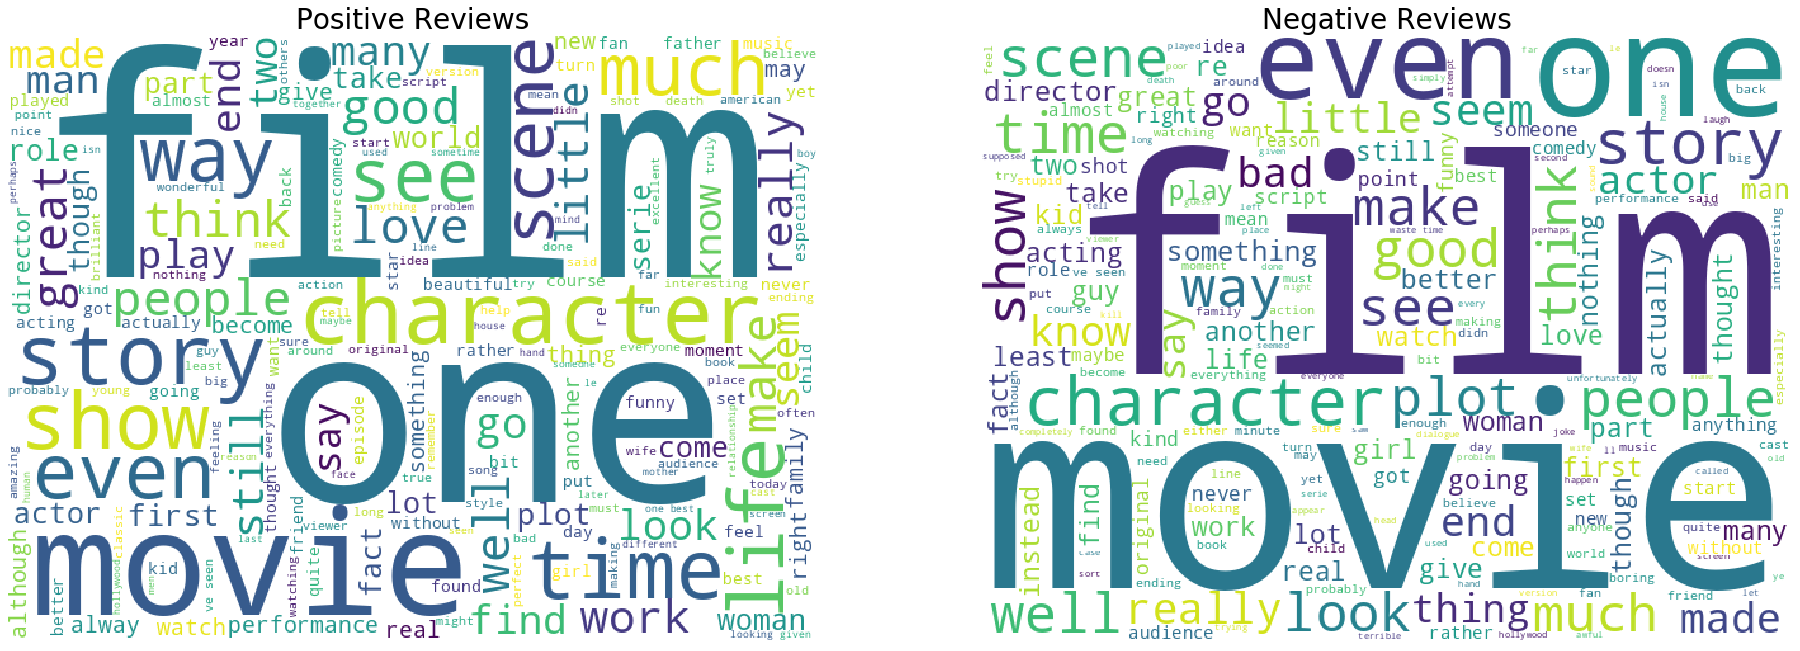

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[32,18])
cloud1 = WordCloud(background_color='black',width=640,height=480).generate(' '.join(pos))
cloud2 = WordCloud(background_color='black', width=640,height=480).generate(' '.join(neg))

ax1.imshow(cloud1)
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=28)

ax2.imshow(cloud2)
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=28)
plt.show()

# Five fold validation

In [53]:
chunk_size = df.shape[0]//5

def determine_class(row):
    if row['_pos'] == 0 and row['_neg'] == 0:
        return np.NAN
    if row['_pos'] >= row['_neg']:
        return 'pos'
    else:
        return 'neg'

In [54]:
def get_conditional(word, sentiment, smooth):
        if smooth:
            if word not in word_counts:
                wc = 0
            else:
                wc = word_counts[word][sentiment]
            return wc+1/(num_sentiment[sentiment]+len(vocabulary['train']))
        if word not in word_counts:
            return 0
        return word_counts[word][sentiment]/num_sentiment[sentiment]

def get_posterior(document, sentiment, corpus, smooth=False):
    p = num_sentiment[sentiment]/corpus.shape[0]
    #print("# of {} records:{}, # of records{}, P({})={}".format(sentiment, num_sentiment[sentiment],train_df.shape[0], sentiment,p))
    for word in document:
        #print('P({}|{}) = {}'.format(word, sentiment, get_conditional(word, sentiment)))
        p *= get_conditional(word, sentiment, smooth)
        #print("P(class={}| {}) = {}\n\n".format(sentiment, ','.join(document),p))
    return p

In [55]:
def prepare_vocab(df, dataset):
    wc = []
    df['_data'].apply(lambda data: wc.extend(data))
    wc = dict(collections.Counter(wc))
    print('Distinct words in {}: {}'.format(dataset, len(wc.keys())))
    wc = [ k for k,v in wc.items() if v>5 ]
    print('Distinct words in {} after removing rare words: {}'.format(dataset, len(wc)))
    return wc

In [56]:
accuracy = []
for i in range(5):
    print("Pass#{}".format(i+1))
    dev_start = i*chunk_size
    dev_end = dev_start + chunk_size
    vocabulary = {}
    word_counts = {}
    num_sentiment = {}
    
    dev_df = df[dev_start:dev_end].copy()
    train_df = pd.concat([df[0:dev_start], df[dev_end:df.shape[0]]])
    
    vocabulary['train'] = prepare_vocab(train_df, 'Train Set')
    train_df['_data'] = train_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['train']))

    vocabulary['dev'] = prepare_vocab(dev_df, 'Dev Set')
    dev_df['_data'] = dev_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['dev']))
    
    num_sentiment['pos'] = train_df[train_df['_class']=='pos'].shape[0]
    num_sentiment['neg'] = train_df[train_df['_class']=='neg'].shape[0]
    
    for word in vocabulary['train']:
        docs_with_word = train_df[train_df['_data'].map(set([word]).issubset)]
        pos_docs_with_word = docs_with_word[docs_with_word['_class']=='pos'].shape[0]
        neg_docs_with_word = docs_with_word[docs_with_word['_class']=='neg'].shape[0]
        word_counts[word] = {'pos': pos_docs_with_word, 'neg': neg_docs_with_word}
    
    dev_df['_pos'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'pos', train_df))
    dev_df['_neg'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'neg', train_df))
    dev_df['_predicted_class'] = dev_df.apply(determine_class,axis=1)
    acc = dev_df[dev_df['_class']==dev_df['_predicted_class']].shape[0]/dev_df.shape[0]
    accuracy.append(acc)
    print("Accuracy:{}\n\n".format(acc))
    print("\nAverage Accuracy on dev set: {}\n".format(mean(accuracy)))

Pass#1
Distinct words in Train Set: 62085
Distinct words in Train Set after removing rare words: 21315
Distinct words in Dev Set: 34798
Distinct words in Dev Set after removing rare words: 10102
Accuracy:0.748


Pass#2
Distinct words in Train Set: 62048
Distinct words in Train Set after removing rare words: 21242
Distinct words in Dev Set: 34949
Distinct words in Dev Set after removing rare words: 10204
Accuracy:0.7446


Pass#3
Distinct words in Train Set: 62275
Distinct words in Train Set after removing rare words: 21398
Distinct words in Dev Set: 34244
Distinct words in Dev Set after removing rare words: 9902
Accuracy:0.7562


Pass#4
Distinct words in Train Set: 62237
Distinct words in Train Set after removing rare words: 21369
Distinct words in Dev Set: 34269
Distinct words in Dev Set after removing rare words: 9852
Accuracy:0.7572


Pass#5
Distinct words in Train Set: 62085
Distinct words in Train Set after removing rare words: 21311
Distinct words in Dev Set: 34787
Distinct words 

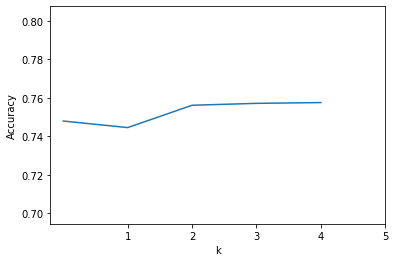

In [58]:
k = [1,2,3,4,5]
plt.plot(accuracy, k)
plt.ylim(min(accuracy)-0.05, max(accuracy)+0.05)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.xticks(k)
plt.show()

# Apply Smoothing

## Laplace smoothing

In [59]:
dev_df['_pos'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'pos', train_df, True))
dev_df['_neg'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'neg', train_df, True))
dev_df['_predicted_class'] = dev_df.apply(determine_class,axis=1)
acc = dev_df[dev_df['_class']==dev_df['_predicted_class']].shape[0]/dev_df.shape[0]
print("Accuracy after applying Laplace Smoothing :{}\n\n".format(acc))

Accuracy after applying Laplace Smoothing :0.7988




Rant about why smoothing made it worse

# Top 10 Positive and Negative words

In [60]:
pos_words = []
dev_df[(dev_df['_class']=='pos') 
       & (dev_df['_class']==dev_df['_predicted_class'])
      ]['_data'].apply(pos_words.extend)
pos_words = collections.Counter(pos_words)
print("Top 10 words that predict positive review\n")
pprint(pos_words.most_common(10))
neg_words = []
dev_df[(dev_df['_class']=='neg') 
       & (dev_df['_class']==dev_df['_predicted_class'])
      ]['_data'].apply(neg_words.extend)
neg_words = collections.Counter(neg_words)
print("\n\nTop 10 words that predict negative review\n")
pprint(neg_words.most_common(10))

Top 10 words that predict positive review

[('film', 1377),
 ('one', 1373),
 ('movie', 1319),
 ('like', 971),
 ('time', 966),
 ('good', 834),
 ('well', 828),
 ('great', 813),
 ('story', 802),
 ('see', 797)]


Top 10 words that predict negative review

[('movie', 1238),
 ('one', 915),
 ('film', 902),
 ('like', 820),
 ('good', 623),
 ('even', 619),
 ('time', 619),
 ('bad', 608),
 ('would', 553),
 ('get', 532)]


# Use the tuned hyper-parameters to predict the test set

In [64]:
test_df = load('data/aclImdb','test')

In [65]:
test_df['_data'] = test_df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
vocabulary['test'] = prepare_vocab(test_df, 'Test Set')
vocabulary['train'] = prepare_vocab(df, 'Train Set for final prediction')
test_df['_data'] = test_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['test']))
test_df.head()

Distinct words in Test Set: 67336
Distinct words in Test Set after removing rare words: 23216
Distinct words in Train Set for final prediction: 68212
Distinct words in Train Set for final prediction after removing rare words: 23698


,_document,_data,_class
0,data/aclImdb/test/neg/929_2.txt,"{hollywood, myth, comparison, something, want,...",neg
1,data/aclImdb/test/neg/995_1.txt,"{couldn, along, bear, obviously, wasn, watchin...",neg
2,data/aclImdb/test/neg/8544_4.txt,"{style, go, acting, gratuitous, lack, goddess,...",neg
3,data/aclImdb/test/neg/5691_1.txt,"{comment, go, human, acting, main, watching, s...",neg
4,data/aclImdb/test/neg/11771_1.txt,"{big, already, made, go, really, minute, part,...",neg


In [ ]:
word_counts = {}
num_sentiment = {}


num_sentiment['pos'] = df[df['_class']=='pos'].shape[0]
num_sentiment['neg'] = df[df['_class']=='neg'].shape[0]

for word in vocabulary['train']:
    docs_with_word = df[df['_data'].map(set([word]).issubset)]
    pos_docs_with_word = docs_with_word[docs_with_word['_class']=='pos'].shape[0]
    neg_docs_with_word = docs_with_word[docs_with_word['_class']=='neg'].shape[0]
    word_counts[word] = {'pos': pos_docs_with_word, 'neg': neg_docs_with_word}

In [ ]:
test_df[:500]['_pos'] = test_df[:500]['_data'].apply(lambda doc: get_posterior(doc, 'pos', df, True))
test_df[:500]['_neg'] = test_df[:500]['_data'].apply(lambda doc: get_posterior(doc, 'neg', df, True))
test_df[:500]['_predicted_class'] = test_df.apply(determine_class,axis=1)
acc = test_df[:500][test_df['_class']==['_predicted_class']].shape[0]/test_df[:500].shape[0]
print("Accuracy over test set:{}\n\n".format(acc))